In [1]:
from zipfile import ZipFile
import pandas
import seaborn as sns
from io import BytesIO
import requests
import urllib.request

In [2]:
%matplotlib inline 

In [3]:
result = requests.get("https://www.covid19.admin.ch/api/data/20220117-ylc277il/downloads/sources-csv.zip")

In [4]:
zf = ZipFile(BytesIO(result.content))

dfs = dict()
for item in zf.namelist():
    if item.endswith('.csv'):
        df = pandas.read_csv(zf.open(item), encoding='latin-1', error_bad_lines=False, low_memory=False)
        dfs[item] = df

[key for key in dfs.keys() if 'HOSP' in key.upper()]

['data/COVID19Hosp_geoRegion.csv',
 'data/COVID19Hosp_vaccpersons.csv',
 'data/COVID19Hosp_geoRegion_w.csv',
 'data/COVID19Hosp_geoRegion_AKL10_w.csv',
 'data/COVID19Hosp_vaccpersons_AKL10_w.csv',
 'data/COVID19Hosp_geoRegion_sex_w.csv',
 'data/COVID19Hosp_vaccpersons_sex_w.csv',
 'data/COVID19HospCapacity_geoRegion.csv']

In [5]:
dfs['data/COVID19HospCapacity_geoRegion.csv'].columns

Index(['date', 'geoRegion', 'ICU_AllPatients', 'ICU_Covid19Patients',
       'ICU_Capacity', 'Total_AllPatients', 'Total_Covid19Patients',
       'Total_Capacity', 'ICU_NonCovid19Patients', 'ICU_FreeCapacity',
       'Total_NonCovid19Patients', 'Total_FreeCapacity', 'timeframe_14d',
       'timeframe_28d', 'timeframe_phase2', 'timeframe_phase2b',
       'timeframe_phase3', 'timeframe_phase4', 'timeframe_phase5',
       'timeframe_all', 'Total_Capacity_mean15d', 'Total_AllPatients_mean15d',
       'Total_Covid19Patients_mean15d', 'Total_NonCovid19Patients_mean15d',
       'Total_FreeCapacity_mean15d', 'ICU_Capacity_mean15d',
       'ICU_AllPatients_mean15d', 'ICU_Covid19Patients_mean15d',
       'ICU_NonCovid19Patients_mean15d', 'ICU_FreeCapacity_mean15d',
       'type_variant', 'ICUPercent_AllPatients',
       'ICUPercent_NonCovid19Patients', 'ICUPercent_Covid19Patients',
       'ICUPercent_FreeCapacity', 'ICUPercent_Capacity',
       'TotalPercent_AllPatients', 'TotalPercent_NonCovid1

In [6]:
df_hosp_ch = dfs['data/COVID19HospCapacity_geoRegion.csv'][['date', 'geoRegion', 'ICU_NonCovid19Patients', 'ICU_Covid19Patients',
       'ICU_Capacity', 'Total_NonCovid19Patients', 'Total_Covid19Patients',
       'Total_Capacity']][dfs['data/COVID19HospCapacity_geoRegion.csv']['geoRegion'] == 'CH'][dfs['data/COVID19HospCapacity_geoRegion.csv']['type_variant'] == 'fp7d']

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [7]:
dfs['data/COVID19HospCapacity_geoRegion.csv'].columns

Index(['date', 'geoRegion', 'ICU_AllPatients', 'ICU_Covid19Patients',
       'ICU_Capacity', 'Total_AllPatients', 'Total_Covid19Patients',
       'Total_Capacity', 'ICU_NonCovid19Patients', 'ICU_FreeCapacity',
       'Total_NonCovid19Patients', 'Total_FreeCapacity', 'timeframe_14d',
       'timeframe_28d', 'timeframe_phase2', 'timeframe_phase2b',
       'timeframe_phase3', 'timeframe_phase4', 'timeframe_phase5',
       'timeframe_all', 'Total_Capacity_mean15d', 'Total_AllPatients_mean15d',
       'Total_Covid19Patients_mean15d', 'Total_NonCovid19Patients_mean15d',
       'Total_FreeCapacity_mean15d', 'ICU_Capacity_mean15d',
       'ICU_AllPatients_mean15d', 'ICU_Covid19Patients_mean15d',
       'ICU_NonCovid19Patients_mean15d', 'ICU_FreeCapacity_mean15d',
       'type_variant', 'ICUPercent_AllPatients',
       'ICUPercent_NonCovid19Patients', 'ICUPercent_Covid19Patients',
       'ICUPercent_FreeCapacity', 'ICUPercent_Capacity',
       'TotalPercent_AllPatients', 'TotalPercent_NonCovid1

In [8]:
df_hosp_ch_total = df_hosp_ch[['date', 'geoRegion', 'Total_NonCovid19Patients', 'Total_Covid19Patients', 'Total_Capacity']]
df_hosp_ch_total['Total'] = df_hosp_ch_total.loc[:,'Total_NonCovid19Patients'] + df_hosp_ch_total.loc[:,'Total_Covid19Patients']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [9]:
df_hosp_ch_total_2020 = df_hosp_ch_total[(df_hosp_ch_total['date'] <= '2020-31-12') & (df_hosp_ch_total['date'] > '2019-31-12')]
df_hosp_ch_total_2021 = df_hosp_ch_total[(df_hosp_ch_total['date'] <= '2021-31-12') & (df_hosp_ch_total['date'] > '2020-31-12')]

In [10]:
df_hosp_ch_total_2020['dayOfYear'] = pandas.to_datetime(df_hosp_ch_total_2020['date']).dt.dayofyear
df_hosp_ch_total_2021['dayOfYear'] = pandas.to_datetime(df_hosp_ch_total_2021['date']).dt.dayofyear

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [11]:
df_hosp_ch_total_2021

,date,geoRegion,Total_NonCovid19Patients,Total_Covid19Patients,Total_Capacity,Total,dayOfYear
35151,2021-01-01,CH,10892.0,2528.0,22225.0,13420.0,1
35152,2021-01-02,CH,10970.0,2568.0,22128.0,13538.0,2
35153,2021-01-03,CH,11444.0,2661.0,22295.0,14105.0,3
35154,2021-01-04,CH,12428.0,2697.0,22573.0,15125.0,4
35155,2021-01-05,CH,13692.0,2689.0,22704.0,16381.0,5
...,...,...,...,...,...,...,...
35511,2021-12-27,CH,13269.0,1721.0,22370.0,14990.0,361
35512,2021-12-28,CH,13875.0,1698.0,22393.0,15573.0,362
35513,2021-12-29,CH,13883.0,1731.0,22354.0,15614.0,363
35514,2021-12-30,CH,13653.0,1653.0,22166.0,15306.0,364


<AxesSubplot:xlabel='dayOfYear'>

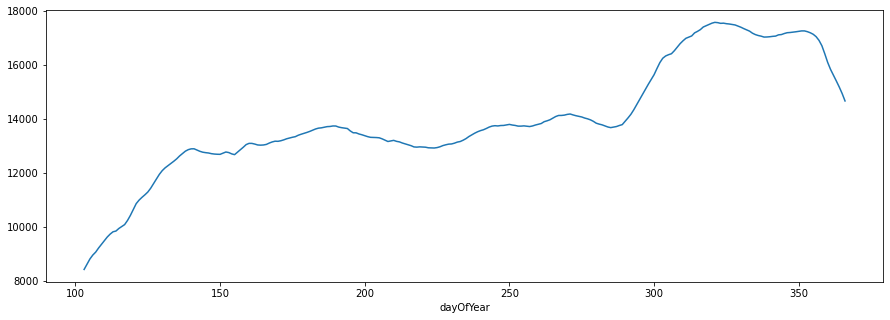

In [31]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
df_hosp_ch_total_2020.set_index('dayOfYear', inplace=False).rolling(window=14).mean()['Total'].plot()

In [32]:
df_2020 = df_hosp_ch_total_2020.set_index('dayOfYear', inplace=False).rolling(window=14).mean()['Total']
df_2021 = df_hosp_ch_total_2021.set_index('dayOfYear', inplace=False).rolling(window=14).mean()['Total']
df_2020.name = 'Hospitalisations 2020'
df_2021.name = 'Hospitalisations 2021'
output = pandas.DataFrame([df_2020, df_2021]).transpose()

In [33]:
output

,Hospitalisations 2020,Hospitalisations 2021
dayOfYear,,
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
...,...,...
362,15614.857143,16663.785714
363,15396.785714,16420.214286
364,15175.714286,16148.714286


<AxesSubplot:xlabel='dayOfYear'>

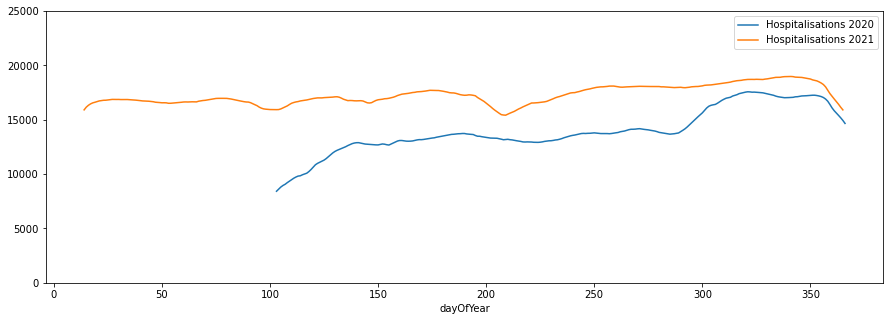

In [34]:
output.plot(ylim=(0, 25000))